Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


437/437 ━━━━━━━━━━━━━━━━━━━━ 249s 496ms/step - accuracy: 0.7116 - loss: 0.6203 - val_accuracy: 0.7138 - val_loss: 0.6198 - learning_rate: 3.0000e-04
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 216s 491ms/step - accuracy: 0.7187 - loss: 0.5960 - val_accuracy: 0.7135 - val_loss: 0.6073 - learning_rate: 3.0000e-04
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 216s 491ms/step - accuracy: 0.7338 - loss: 0.5806 - val_accuracy: 0.7173 - val_loss: 0.5943 - learning_rate: 3.0000e-04
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 213s 485ms/step - accuracy: 0.7441 - loss: 0.5640 - val_accuracy: 0.7133 - val_loss: 0.5742 - learning_rate: 3.0000e-04
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 214s 488ms/step - accuracy: 0.7566 - loss: 0.5459 - val_accuracy: 0.7221 - val_loss: 0.5874 - learning_rate: 3.0000e-04
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 222s 507ms/step - accuracy: 0.7545 - loss: 0.5393 - val_accuracy: 0.7247 - val_loss: 0.5669 - learning_rate: 3.0000e-04
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 249s 567ms/

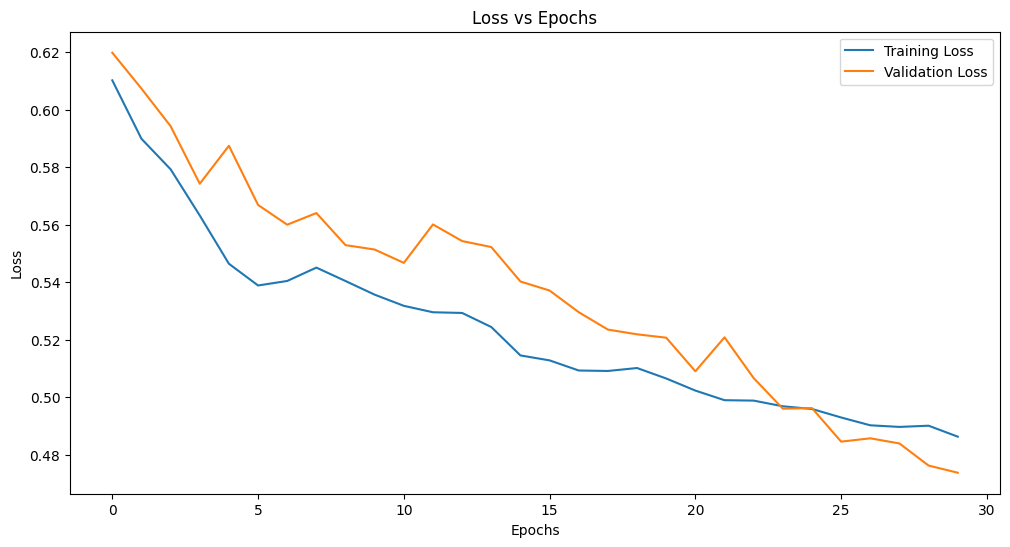

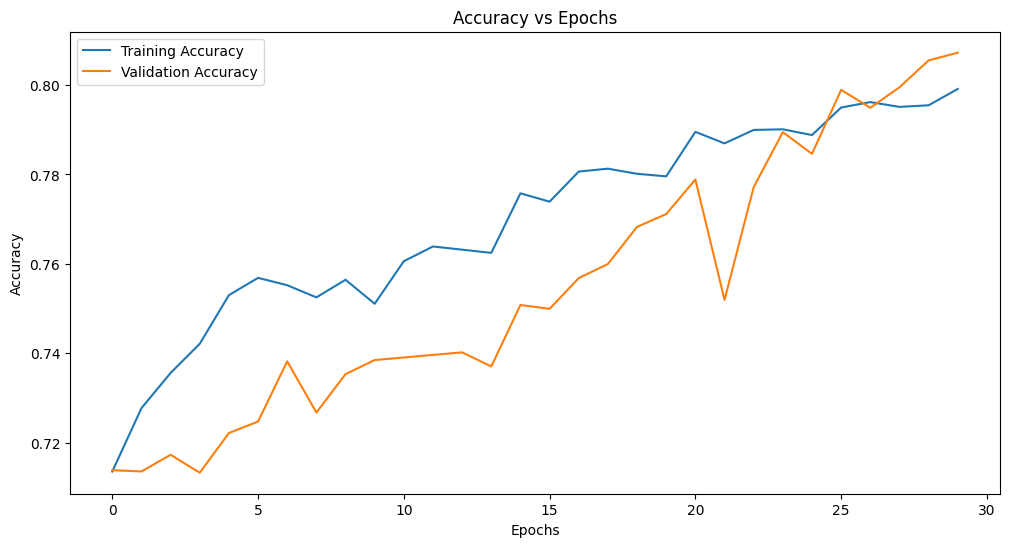

In [1]:
import os
import time
import logging
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# Set up logging
# log_dir = '/kaggle/working/FinalLogs'
# os.makedirs(log_dir, exist_ok=True)
# log_file = os.path.join(log_dir, 'vit_model_training.log')
# logging.basicConfig(
#     filename=log_file,
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s'
# )


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


def create_vit_model(
        input_shape=(128, 128, 3),
        patch_size=16,
        num_patches=64,
        projection_dim=64,
        transformer_layers=8,
        num_heads=4,
        transformer_units=[128, 64],
        mlp_head_units=[256, 128],
        dropout_rate=0.3
):
    inputs = layers.Input(shape=input_shape)

    # Create patches
    patches = Patches(patch_size)(inputs)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout_rate)(x3)
        x3 = layers.Dense(transformer_units[1], activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(dropout_rate)(x3)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Global average pooling
    representation = layers.GlobalAveragePooling1D()(representation)

    # MLP head
    features = layers.Dense(mlp_head_units[0], activation=tf.nn.gelu)(representation)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(mlp_head_units[1], activation=tf.nn.gelu)(features)
    features = layers.Dropout(dropout_rate)(features)

    # Classification head
    outputs = layers.Dense(1, activation="sigmoid")(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def load_and_preprocess_data(data_dir):
    """
    Load images and labels from directory
    Returns X (images), y (labels)
    """
    images = []
    labels = []

    for label, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            # Read and resize image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize

            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)


def create_dynamic_validation_generator(X_train, y_train, batch_size=32):
    """
    Create a dynamic validation generator using train_test_split
    """
    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation
    val_datagen = ImageDataGenerator()

    # Create generators
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
        shuffle=True
    )

    val_generator = val_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False
    )

    return train_generator, val_generator


def train_model(model, train_generator, validation_generator, epochs=30):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=3e-4,
        weight_decay=1e-4
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"],
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'best_vit_model.keras',
            monitor="val_loss",
            save_best_only=True
        ),
        
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=30,
        callbacks=callbacks,
        verbose=1
    )

    return history


def plot_performance(history):
    # Extracting the loss and accuracy values
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot
    plt.savefig('training_performance.png')

    # Display the plot
    plt.show()

    # Plotting the accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Save the plot
    #plt.savefig('training_performance.png')

    # Display the plot
    plt.show()

    return history, plot_performance


def evaluate_model(model, test_generator, y_test):
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    # Get true labels and predictions
    y_true = y_test
    y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return test_loss, test_accuracy, accuracy, precision, recall, f1


def main():
    # Load and preprocess data
    train_data_dir = '/kaggle/input/chest-x-ray-images/FinalData (copy)/FinalData (copy)/train'
    test_data_dir = '/kaggle/input/chest-x-ray-images/FinalData (copy)/FinalData (copy)/test'
    X_train, y_train = load_and_preprocess_data(train_data_dir)
    X_test, y_test = load_and_preprocess_data(test_data_dir)

    # Create dynamic validation generator
    train_generator, validation_generator = create_dynamic_validation_generator(X_train, y_train)

    # Create and train model
    vit_model = create_vit_model()
    start_time = time.time()
    history = train_model(vit_model, train_generator, validation_generator)
    execution_time = time.time() - start_time

    # Log training time
    logging.info(f'ViT Model - Training Time: {execution_time:.2f} seconds')

    # Evaluate model on test set
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)
    test_loss, test_accuracy, accuracy, precision, recall, f1 = evaluate_model(vit_model, test_generator, y_test)

    # Log and print results
    logging.info(f'ViT Model - Test Loss: {test_loss:.4f}')
    logging.info(f'ViT Model - Test Accuracy: {test_accuracy:.4f}')
    logging.info(f'ViT Model - Accuracy: {accuracy:.4f}')
    logging.info(f'ViT Model - Precision: {precision:.4f}')
    logging.info(f'ViT Model - Recall: {recall:.4f}')
    logging.info(f'ViT Model - F1 Score: {f1:.4f}')

    print(f'ViT Model - Test Loss: {test_loss:.4f}')
    print(f'ViT Model - Test Accuracy: {test_accuracy:.4f}')
    print(f'ViT Model - Accuracy: {accuracy:.4f}')
    print(f'ViT Model - Precision: {precision:.4f}')
    print(f'ViT Model - Recall: {recall:.4f}')
    print(f'ViT Model - F1 Score: {f1:.4f}')

    plot_performance(history)

if __name__ == '__main__':
    main()
